In [23]:
#%pip install pandas 
#%pip install matplotlib
#%pip install scikit-learn
#%pip install imbalanced-learn

In [24]:
import pandas as pd
filepath = "./data/catB_train.parquet" 
df = pd.read_parquet(filepath)
print(f'There are {df.shape[0]} observations and {df.shape[1]} features in this dataset.', '\n')

There are 17992 observations and 304 features in this dataset. 



In [25]:
# Target Column
df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)

Exploratory Data Analysis

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Add the feature age
df = df[df['cltdob_fix']!='None']
df['cltdob_fix'] = pd.to_datetime(df.iloc[:, 6], format ='mixed')
df['age'] = 2024-df['cltdob_fix'].dt.year

In [27]:
# Check whether the dataset is balanced
from collections import Counter

y = df["f_purchase_lh"]
X = df.drop(columns=['f_purchase_lh'])

print(f'There are {Counter(y)[1]} zeroes in the target columns, constituting {round(Counter(y)[1]/len(y)*100, 2)} % of the all observations.', '\n')
# From the result, we can see that this dataset is highly imbalanced. 

There are 708 zeroes in the target columns, constituting 3.94 % of the all observations. 



In [28]:
# Find Numerical variables in X 
numeric_cols = X.select_dtypes(include=["int32", "int64", "float64"]).columns
X_numeric = X[numeric_cols]
print(f'There are {len(numeric_cols)} numerical features.', '\n')

There are 90 numerical features. 



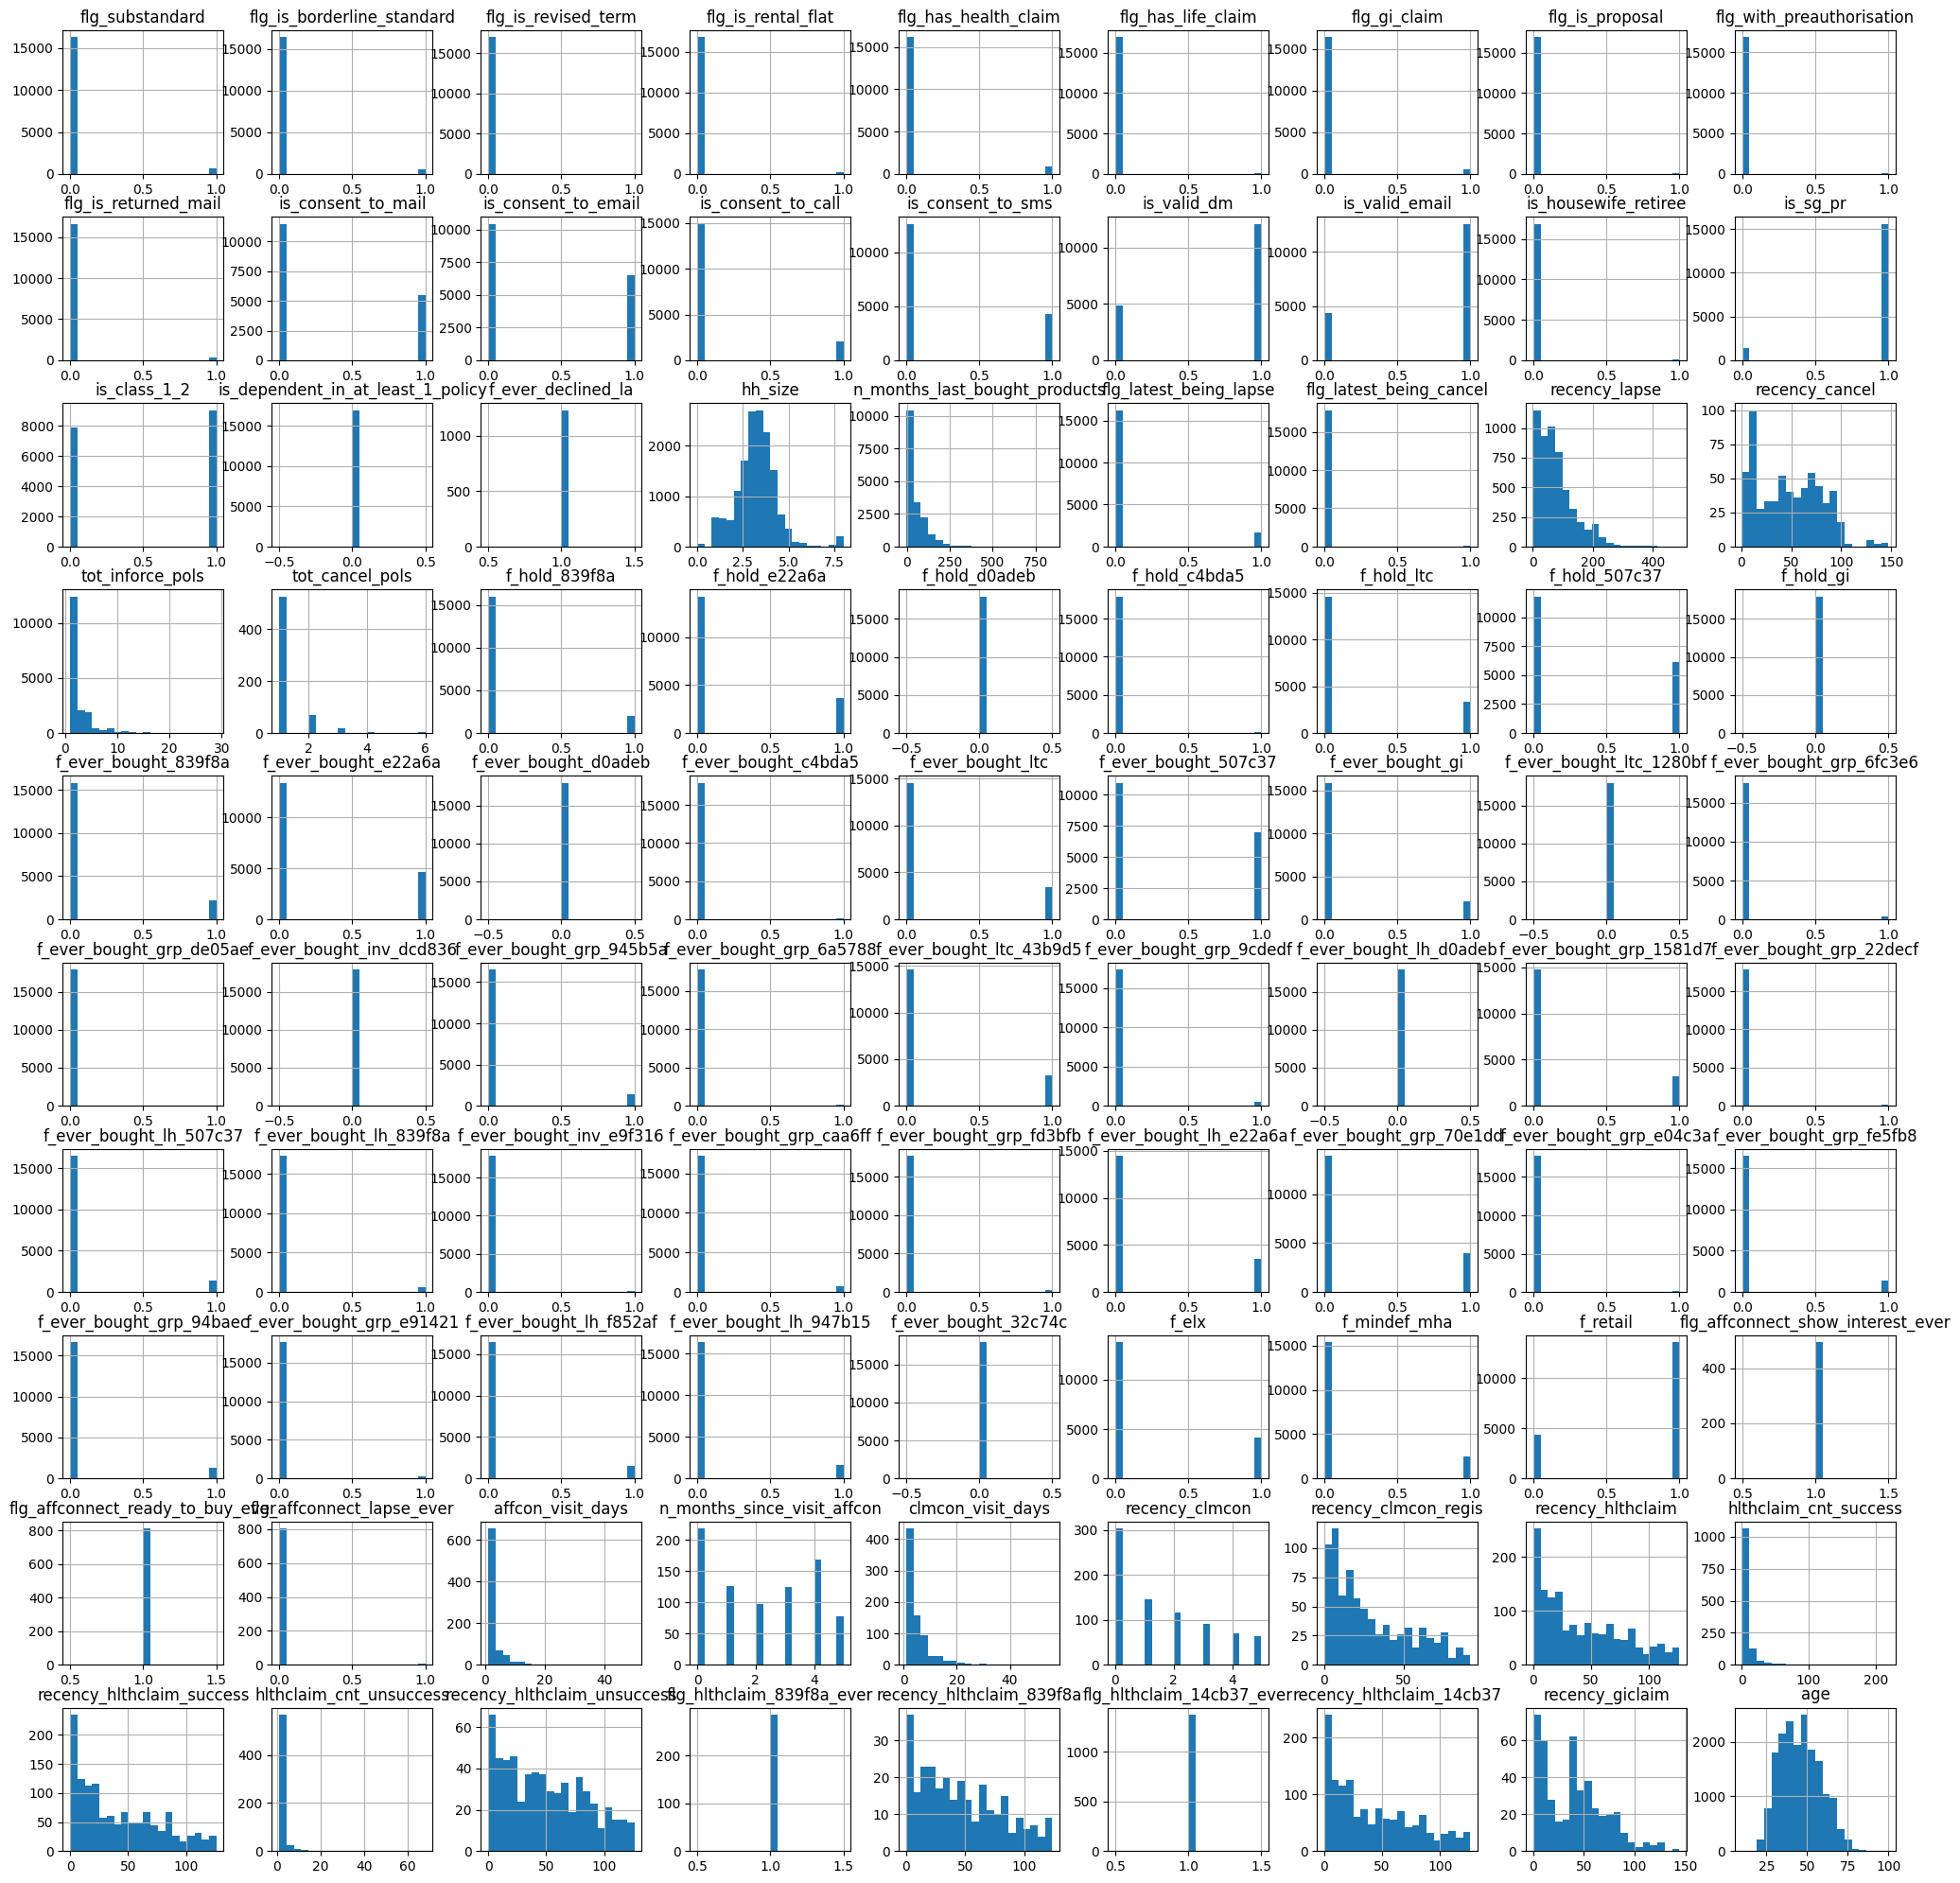

In [29]:
# To find the distributions and outlier in the each numerical variable
X_numeric.hist(figsize=(25,25),bins=20)
plt.show()

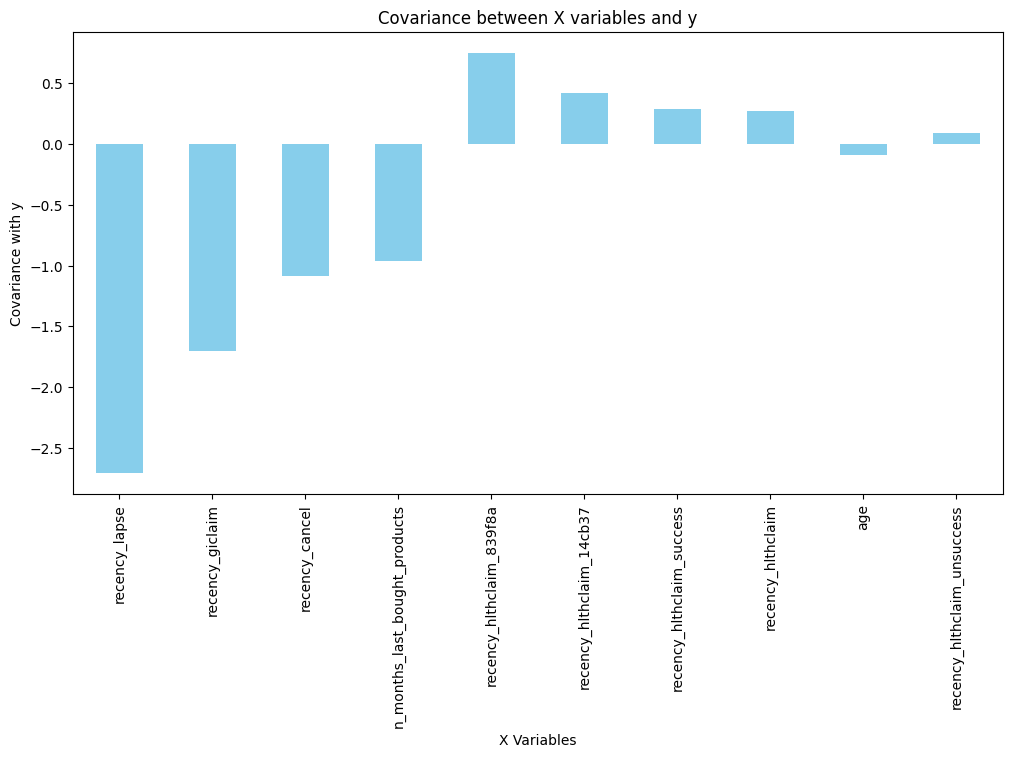

In [30]:
# Covariance
import matplotlib.pyplot as plt

# Concatenate X and y to create a new DataFrame for plotting
data_for_plot = pd.concat([X_numeric, y], axis=1)

# Calculate the covariance between each variable in X and y
covariance_with_y = data_for_plot.cov().iloc[:-1, -1]

# Filter X variables based on covariance threshold
top_10_features = covariance_with_y.abs().nlargest(10).index

# Plot the bar plot
covariance_with_y[top_10_features].plot(kind='bar', color='skyblue', figsize=(12, 6))
plt.title('Covariance between X variables and y')
plt.xlabel('X Variables')
plt.ylabel('Covariance with y')
plt.show()


C:\Users\65835\AppData\Local\Temp\ipykernel_16000\2672896279.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age.groupby('age_bin')['f_purchase_lh'].value_counts().unstack().plot(kind='bar', stacked=True)


<AxesSubplot:xlabel='age_bin'>

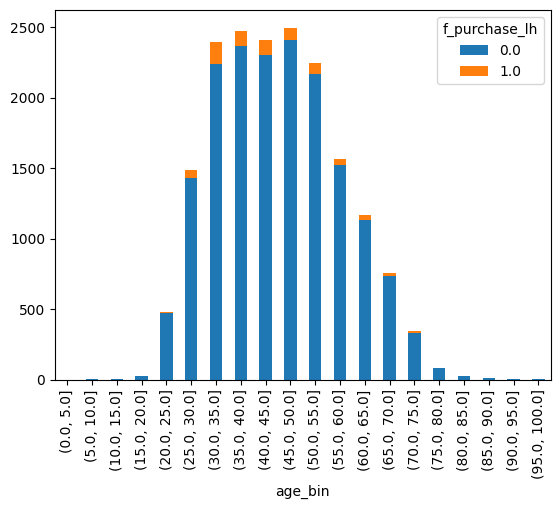

In [31]:
# Visualising Age
age = pd.concat([df['age'], df["f_purchase_lh"] ], axis=1)
age['age_bin'] = pd.cut(age['age'], np.linspace(0,100,21))
age.groupby('age_bin')['f_purchase_lh'].value_counts().unstack().plot(kind='bar', stacked=True)

# From the result, we can see that most subscribers are aged 25 to 75. 

C:\Users\65835\AppData\Local\Temp\ipykernel_16000\1668954758.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recency_lapse.groupby('recency_lapse_bin')['f_purchase_lh'].value_counts().unstack().plot(kind='bar', stacked=True)


<AxesSubplot:xlabel='recency_lapse_bin'>

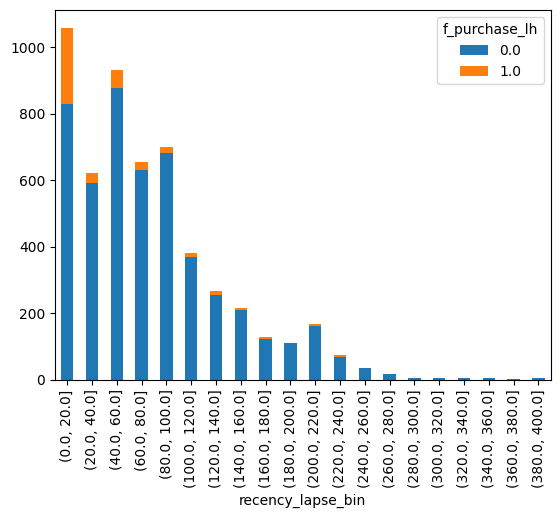

In [32]:
# Visualising recency_lapse
recency_lapse = pd.concat([df['recency_lapse'], df["f_purchase_lh"] ], axis=1)
recency_lapse['recency_lapse_bin'] = pd.cut(recency_lapse['recency_lapse'], np.linspace(0,400,21))
recency_lapse.groupby('recency_lapse_bin')['f_purchase_lh'].value_counts().unstack().plot(kind='bar', stacked=True)

# From the result, we can see that the conversion rate is higher if the recency_lapse is low (provided customers have had a policy lapsed)

Pre-processing

In [33]:
# Replace missing vlaues in numeric columns with -1
X_numeric = X_numeric.apply(lambda x: x.fillna(-1))

# One-hot encoding for potencially categorical data 
non_numeric_cols = X.select_dtypes(include=["string", "object"]).columns
non_numeric_keep = []
for col in non_numeric_cols:
    if X[col].nunique() <= 10:
        if X[col].nunique() > 1: # Discard variables with zero variance
            non_numeric_keep.append(col)
X_non_numeric = pd.get_dummies(X[non_numeric_keep], dtype=float)

X = pd.concat([X_numeric, X_non_numeric], axis=1)

# Discard variables with low variance
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(0.05))
sel.fit(X)
X = X[X.columns.values[sel.get_support()]]

In [34]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Balancing Data by generating random samples of the minority group (y=1)
ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

# Balancing Data by generating synthetic data in the training group
smote = SMOTE(random_state=10)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

In [35]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=15, random_state=15, class_weight='balanced')

param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1', cv=3)
grid_search_rf.fit(X_train, y_train)

# The best-performing hyperparameters from grid search 
best_params_rf = grid_search_rf.best_params_

# Predict y values of testing group 
y_val_pred_rf = grid_search_rf.best_estimator_.predict(X_val)

CPU times: total: 22.8 s
Wall time: 27.7 s


Evaluate Model using Testing Group

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,precision_score, recall_score

accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
conf_matrix_rf = confusion_matrix(y_val, y_val_pred_rf)
f1_rf = f1_score(y_val, y_val_pred_rf)
precision_rf = precision_score(y_val, y_val_pred_rf)
recall_rf = recall_score(y_val, y_val_pred_rf)

print("\nRandom Forest Results:")
print(f"Best Hyperparameters: {best_params_rf}")
print(f"Accuracy: {accuracy_rf}")
print("Confusion Matrix:")
print(conf_matrix_rf)
print(f"F1 Score: {f1_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")


Random Forest Results:
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 0.8898163606010017
Confusion Matrix:
[[3123  325]
 [  71   75]]
F1 Score: 0.27472527472527475
Precision: 0.1875
Recall: 0.5136986301369864


In [39]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    for ind in hidden_data.index:
        if hidden_data['cltdob_fix'][ind] == 'None': hidden_data['cltdob_fix'][ind] = '1979-01-01' 
    hidden_data['cltdob_fix'] = pd.to_datetime(hidden_data['cltdob_fix'], format ='mixed')
    hidden_data['age'] = 2024-hidden_data['cltdob_fix'].dt.year

    temp1 = hidden_data[numeric_cols].apply(lambda x: x.fillna(-1))
    temp2 = pd.get_dummies(hidden_data[non_numeric_keep], dtype=float)
    hidden_data = pd.concat([temp1, temp2], axis=1)

    result = list(grid_search_rf.best_estimator_.predict(hidden_data))
    return result

Cell to check testing_hidden_data function

In [40]:
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

C:\Users\65835\AppData\Local\Temp\ipykernel_16000\4265231224.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  if hidden_data['cltdob_fix'][ind] == 'None': hidden_data['cltdob_fix'][ind]  = '1979-01-01'
C:\Users\65835\AppData\Local\Temp\ip

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- annual_income_est_B.100K-200K
- ape_grp_de05ae_0.00
- ape_grp_de05ae_120.00
- ape_grp_de05ae_1274.40
- ape_grp_de05ae_238.56
- ...
